In [322]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import re
import numpy as np
os.getcwd()

'/Users/carolinesofieljorring/Desktop/Social-Data-Project'

In [323]:
# load tree data from the municipality of Copenhagen 
cols = ['id','kategori','ny_dm_element','traeart','slaegtsnavn','planteaar','faeldningsaar','bydelsnavn','byrumstype','vejnavn','fritrumsprofil','stammeomfang','placering','omgivelse','reg_dato','opdateret_dato','wkb_geometry']
df = pd.read_csv('raw_data/trae_basis.csv',sep=',',usecols=cols)

# prepare tree data for analysis
dfnew = df[df["planteaar"] >= 2000] # get data from 2000 and after 
dfnew = dfnew.dropna(subset=['planteaar']) # remove samples with unknown plant year 
dfnew.columns = ['category','id','type','tree_species','species','year','cut_year','district','district_type','street','space_profile','trunk_size','street_location','surroundings','register_date','update_date','coordinates']
dfnew['year'] = dfnew['year'].apply(int)

# get top 10 tree species 
tree_species = dfnew["species"].value_counts().sort_values(ascending = False)[1:11].index.to_list()
dfnew.to_csv('data/df_tree.csv', index=False)

In [324]:
# number of trees 
dfnew1 = dfnew.groupby(['year','district']).size().reset_index()
dfnew1.columns = ['year','district','number_of_planted_trees']

# types
dfnew2 = pd.pivot_table(dfnew, values = "id", index = ["year", "district"], columns = ["type"], aggfunc = "count")
dfnew2.columns = [''.join(col) for col in dfnew2.columns]
dfnew2 = dfnew2.reset_index(level=[0,1])

# species
dfnew3 = pd.pivot_table(dfnew, values = "id", index = ["year", "district"], columns = ["species"], aggfunc = "count")
dfnew3 = dfnew3[tree_species]
dfnew3.columns = [''.join(col) for col in dfnew3.columns]
dfnew3 = dfnew3.reset_index(level=[0,1])

# merge the above 3 tables 
temp = pd.merge(dfnew2,dfnew3)
df_tree = pd.merge(dfnew1,temp)

In [325]:
# load income data from the municipality of Copenhagen 
df1 = pd.read_excel('raw_data/2022419113038370864435KKIND3.xlsx', header=2, usecols = "C:Y")
df1.rename(columns = {'Unnamed: 2':'income_type', 'Unnamed: 3':'district'}, inplace = True)
df1['income_type'] = df1['income_type'].fillna(method='ffill')
df1['district'] = df1['district'].str.replace("Bydel - ", "")
df1['district'] = df1['district'].str.replace("/", "-")
df1 = df1[df1['district']!='København i alt']

df_income = df1.melt(id_vars=["district","income_type"],var_name="year", value_name="total")
df_income = (pd.pivot_table(df_income, values = "total", index = ["year", "district"], columns = ["income_type"], aggfunc = "sum")).reset_index()
df_income['year'] = df_income['year'].apply(int)

In [327]:
# merge tree and income data
df_merged = pd.merge(df_tree,df_income,how='outer')
df_merged = df_merged[df_merged.year.isin([2021,2022])==False]
df_merged = df_merged.drop(columns=['0'])

In [334]:
# load education data from the municipality of Copenhagen 
df2 = pd.read_excel('raw_data/2022419114031370864435KKUDD2.xlsx', header =2, usecols = "C:R")
df2.rename(columns = {'Unnamed: 2':'race', 'Unnamed: 3':'education', 'Unnamed: 4':'district'}, inplace = True)
df2['race'] = df2['race'].fillna(method='ffill')
df2['education'] = df2['education'].fillna(method='ffill')
df2['district'] = df2['district'].str.replace("Bydel - ", "")
df2['district'] = df2['district'].str.replace("/", "-")
df2 = df2[df2['district']!='København i alt']

df_education = df2.melt(id_vars=["district","race", "education"], var_name="year", value_name="total_educated")
df_education['year'] = df_education['year'].apply(int)
df_race = (pd.pivot_table(df_education, values = "total_educated", index = ["year", "district"], columns = ["race"], aggfunc = "sum")).reset_index()
df_level = (pd.pivot_table(df_education, values = "total_educated", index = ["year", "district"], columns = ["education"], aggfunc = "sum")).reset_index()

temp1 = pd.merge(df_merged,df_race,how='outer')
df_all = pd.merge(temp1,df_level,how='outer')
df_all.columns

Index(['year', 'district', 'number_of_planted_trees', 'Formede træer',
       'Gade- og allétræer', 'Park- og naturtræer', 'Private træer',
       'Træer i bevoksninger', 'Eg', 'Lind', 'Kirsebær/Blomme', 'Platan',
       'Robinie', 'Røn', 'Æble', 'Ask', 'Løn', 'El',
       'Gennemsnit for alle personer med indkomsten (kr.)',
       'Indkomstbeløb (1.000 kr.)', 'Personer med indkomsten (antal)',
       'Dansk oprindelse', 'Ikke-vestlig oprindelse', 'Vestlig oprindelse',
       'Erhvervsfaglige og korte videregående uddannelser',
       'Grundskole og uoplyst mv.',
       'Gymnasiale uddannelser og adgangsgivende uddannelsesforløb',
       'Lange videregående uddannelser og Ph.d og forskeruddannelser',
       'Mellemlange videregående uddannelser og bacheloruddannelser'],
      dtype='object')

In [330]:
df_all[['Dansk oprindelse','Ikke-vestlig oprindelse','Vestlig oprindelse']].sum(axis=1) == df_all[['Erhvervsfaglige og korte videregående uddannelser',
       'Grundskole og uoplyst mv.',
       'Gymnasiale uddannelser og adgangsgivende uddannelsesforløb',
       'Lange videregående uddannelser og Ph.d og forskeruddannelser',
       'Mellemlange videregående uddannelser og bacheloruddannelser']].sum(axis=1)

0      True
1      True
2      True
3      True
4      True
       ... 
125    True
126    True
127    True
128    True
129    True
Length: 130, dtype: bool

In [46]:
df['X'] = df['wkb_geometry'].apply(get_x)
df['Y'] = df['wkb_geometry'].apply(get_y)
df.dtypes

kategori           object
id                  int64
ny_dm_element      object
traeart            object
slaegtsnavn        object
planteaar         float64
faeldningsaar      object
bydelsnavn         object
byrumstype         object
vejnavn            object
fritrumsprofil     object
stammeomfang       object
placering          object
omgivelse          object
reg_dato           object
opdateret_dato     object
wkb_geometry       object
X                 float64
Y                 float64
dtype: object

In [47]:
def get_x(row):
    x = re.findall(r"[-+]?\d*\.\d+|\d+", row)[0]
    return float(x)
def get_y(row):
    y = re.findall(r"[-+]?\d*\.\d+|\d+", row)[1]
    return float(y)

In [48]:
df['X'] = df['wkb_geometry'].str.extract(r'(\d+.\d+)').astype('float')

In [48]:
df['wkb_geometry'][0]

'POINT (12.506472982261277 55.69325544860847)'

In [3]:
# Idéen med datasættet, hvad vil vi undersøge?
# hvorfor vigtigt? Vigtigt med træer ift. klimaaflastning (CO2), god stemning i byer, træer/grønne områder skaber ro 

# Exploratory analysis
# Location
# Hvor mange træer i Kbh, hvor mange træer i de forskellige bydele
# Hvilke slags træer - overordnet, i de forskellige bydele 
# Geo plot, brug lat,loc

# Hvilke træer
# Hvornår er træerne plantet - i hvilke år plantes der flest
# Hvilke typer træeer er plantet hvornår  
# Hvor store er træerne? Forskel på størrelse ift. bydele 

In [4]:
## Data preprocessing
print(df.shape[0],len(df['id'].unique()))
df.duplicated(subset='id',keep=False) # rows with same id 
df = df.drop_duplicates(subset='id',keep='last') # drop duplicated rows
print(df.duplicated(subset=['id']).any())
print(df.shape[0],len(df['id'].unique()))

62079 62063
False
62063 62063


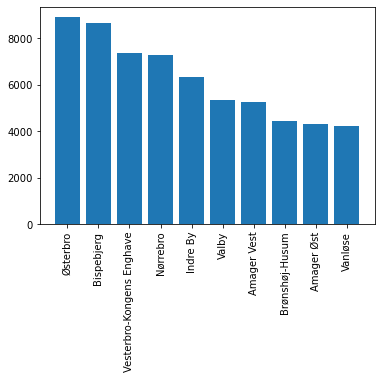

In [5]:
# Exploratory analysis
n_trees = df.shape[0] # number of trees in Copenhagen
count_bydele = df.groupby(['bydelsnavn']).size().sort_values(ascending=False)
plt.figure()
plt.bar(count_bydele.index,count_bydele.values)
plt.xticks(count_bydele.index,rotation=90)
plt.show()

In [6]:
# For bokeh visualisations
from bokeh.plotting import figure
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.layouts import row

In [7]:
df['kategori'].unique()
df['ny_dm_element'].unique()
df['slaegtsnavn'].unique()
df['planteaar'].unique()

array([2008., 2005., 2018., 1960., 2012., 2022., 1977., 2009., 2011.,
       2003., 2021., 1995., 2010., 1980., 1970., 2016., 2015., 2019.,
       2006., 2002., 2001., 1990., 1988., 1998., 1992., 2007., 1947.,
       2014., 2000., 1918., 1900., 2013., 1930., 1940., 1982., 2004.,
       1985., 1972., 1953., 2017., 1969., 2020., 1944., 1950., 1925.,
       1975., 1999., 1951., 1996., 1924., 1920., 1984., 1997., 1989.,
       1942., 1850., 1935., 1948.,   nan, 1936., 1991., 1971., 1976.,
       1994., 1978., 1906., 1965., 1941., 1974., 1973., 1979., 1952.,
          0., 1987., 1961., 1909., 1955., 1905., 1945., 1981., 1986.,
       1773., 1993., 1933., 1983., 1912., 1902., 1907., 1908., 1963.,
       1967., 1915., 1927., 1968., 1959., 1910., 1962., 1870., 1957.,
       1958., 1895., 1966., 1892., 1954., 1932., 1943., 1937., 1931.,
       1891., 1890., 1901., 1926., 1928., 1880., 1919., 1964., 1886.,
       1899., 1913., 1923., 1934., 1922., 1916., 1860., 1914., 1938.,
       1939., 1946.]

In [8]:
df1 = df.groupby(['bydelsnavn','ny_dm_element']).size().reset_index()
df1.columns = ['district','category','count']
df1 = df1[df1['category']!='0'] #drop category '0' for Østerbro

count_category = df.groupby('ny_dm_element').size()
categories = count_category.index[count_category.index != '0'].to_list()
count_bydele = df[df['ny_dm_element'].isin(categories)].groupby(['bydelsnavn']).size().sort_values(ascending=False)

In [11]:
df1['fraction district'] = 0
for name in count_bydele.index:
    df1.loc[df1['district']==name,'fraction district'] = df1.loc[df1['district']==name,'count']/count_bydele[name] #fraction of category in district
df1new = df1.pivot_table('count', ['district'], 'category')
df1new = df1new.reset_index()
df1new

category,district,Formede træer,Gade- og allétræer,Park- og naturtræer,Private træer,Træer i bevoksninger
0,Amager Vest,82,2824,1782,57,490
1,Amager Øst,114,1695,2013,140,335
2,Bispebjerg,473,2165,5402,158,462
3,Brønshøj-Husum,50,1574,2080,68,677
4,Indre By,454,2870,2193,280,535
5,Nørrebro,231,2890,3830,104,211
6,Valby,208,1728,2895,58,463
7,Vanløse,44,1179,2741,44,208
8,Vesterbro-Kongens Enghave,132,4252,2622,53,287
9,Østerbro,414,4178,2552,153,1580


In [12]:
output_notebook()
src1 = ColumnDataSource(df1new)
p1 = figure(plot_width = 900, plot_height = 600,title = "n_categories_by_district", x_axis_label = "district", y_axis_label = "count", x_range=df1new["district"])
bar_cols = df1new.columns[1:]
colors = ['red', 'blue','green','purple','yellow']
items1 = []
bar1 ={}
for indx, i in enumerate(bar_cols):
    print(indx,i)
    bar1[i] = p1.vbar(x="district", top=i, source= src1, width=0.5, legend_label=i, color=colors[indx], muted =True)
    items1.append((bar_cols[indx], [bar1[i]]))
p1.y_range.start = 0
show(p1)

Loading BokehJS ...

0 Formede træer
1 Gade- og allétræer
2 Park- og naturtræer
3 Private træer
4 Træer i bevoksninger


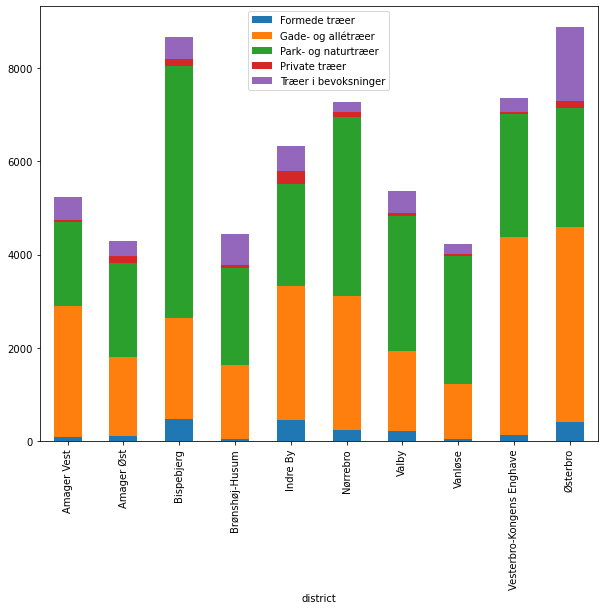

In [38]:
df1new.plot(x='district',kind='bar',stacked=True,figsize=(10,8)).legend(loc='upper center')

In [27]:
import folium
from folium.plugins import HeatMap

In [52]:
## Heatmap 
# 4.2: Heat map 
data = df[df['planteaar'] == 2022.0]

# List comprehension 
heat_data = [[row['Y'],row['X']] for index, row in data.iterrows()]

# Plot it on the map
lat = 55.6761
lon = 12.5683
map = folium.Map(location=[lat, lon],zoom_start = 12)
HeatMap(heat_data,radius=11,blur=10).add_to(map)

# Show map 
map